# Part 1 - Network Design 

Network Design is a critical business problems in many industries. 

For example, a retailer might want to decide where to open a new warehouse to optimize supply chain cost between plants and providers and customers or shops.

Another example is a water distribution company might want to plan improvement of the distribution network, creating new tanks or new pipes.

From a Decision Optimization perspective, some of these problems are part of the Facility Location Problem (FLP) category.

A simple version of this problem is presented here, with multiple commodities (products) and a single period.

Input data is the existing network (nodes and links), with some flow capacities.

The data also includes some plans or predictions of what will be produced at plants or is available from providers, and predictions of the demand expected by shops or customers.

The decisions are where to open a new node.

The problem includes:

* Structural constraints (what enters into a node is what gets out of a node)
* Node constraints:
  * Limited flow capacity
* Node cost:
  * Fixed cost (i.e. cost to open a new node)
  * Variables flow cost (i.e. cost to manage the items for this node)
* Link constraints:
  * Limited capacity
* Link costs:
  * Variable cost according to flows (i.e. transportation cost)

<div class="alert alert-block alert-info">Run this notebook, then close it and run Part 2 - Multiple Scenario Analysis.</div>

## Table of Contents

1. [Load data](#load-data)<br>- [Prepare data](#prep-data)
1. [Create a Decision Optimization model](#do-model)<br>- [Create the decision variables](#decision-variables)
1. [Create the KPIs](#KPI)<br>- [Create the objective](#create-objective)<br>- [Create the constraints](#create-constraints)
1. [Solve the optimization problem](#solve-problem)<br>- [Create solution](#solution)<br>- [Display solution](#display)

#### Insert a project token

When you import this project from the IBM Cloud Pak for Data/watsonx Gallery, a token is automatically generated and inserted at the top of this notebook as a code cell such as the one below:

```python
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='YOUR_PROJECT_ID', project_access_token='YOUR_PROJECT_TOKEN')
pc = project.project_context
```

If you do not see the cell above, follow these steps to enable the notebook to access the data set from the project's resources:

* Click `More -> Insert project token` in the top-right menu section
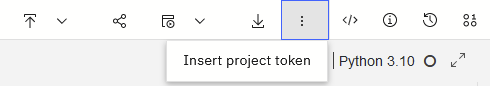

* This should insert a cell at the top of this notebook similar to the example given above.

  > If an error is displayed indicating that no project token is defined, follow [these instructions](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/token.html?audience=wdp&context=data).

* Run the newly inserted cell before proceeding with the notebook execution below

<a id = "load-data"></a>
### Load data

In [2]:
# Import pandas package to manage data as dataframes
import pandas as pd

In [3]:
  files = ['CUSTOMER_NAMES',
           'CUSTOMERS',
           'DCNAMES',
           'DEMAND',
           'DISTRIBUTION_CENTERS',
           'INBOUND_DATA',
           'MILE_MARKERS',
           'OUTBOUND_DATA',
           'PLANT_NAMES',
           'PLANTS',
           'PRODUCTION_DATA',
           'PRODUCTS',
           'STORAGE_DATA',
           'PARAMETERS']

inputs ={}

for f in files:
    df_data = pd.read_csv(project.get_file(f+'.csv'))
    inputs[f] = df_data

<a id = "prep-data"></a>
### Prepare data

The PARAMETERS input table includes:
* The minimum and maximum number of new distribution centers to be considered.
* Some limits on the number of products and customers to consider so that the optimization problem can be reduced and solved by using the CPLEX Community Edition available on all environments.

In [4]:
df_parameters = inputs['PARAMETERS']
df_parameters = df_parameters.set_index(['name'])
MAX_CUSTOMERS = df_parameters.value['MAX_CUSTOMERS']

MAX_PRODUCTS =  df_parameters.value['MAX_PRODUCTS']
print (df_parameters)

               value
name                
MAX_PRODUCTS       1
MAX_CUSTOMERS     30
MIN_OPEN_DCS       1
MAX_OPEN_DCS       3


Here the data is structured.

In [5]:
df_plants = inputs['PLANTS']
plants = df_plants['id'].values.tolist()
df_plants = df_plants.set_index(['id'])

print ('\nPlants:')
print (df_plants)

df_distributionCenters = inputs['DISTRIBUTION_CENTERS']
distributionCenters = df_distributionCenters['id'].values.tolist()
df_distributionCenters = df_distributionCenters.set_index(['id'])

print ('\nDistribution Centers:')
print (df_distributionCenters)

df_products = inputs['PRODUCTS']
if (MAX_PRODUCTS < len(df_products)):
    df_products = df_products.sample(MAX_PRODUCTS)
products = df_products['id'].values.tolist()

print ('\nProducts:')
print (df_products)

df_customers = inputs['CUSTOMERS']
if (MAX_CUSTOMERS < len(df_customers)):
    df_customers = df_customers.sample(MAX_CUSTOMERS)
customers = df_customers['id'].values.tolist()
df_customers = df_customers.set_index(['id'])

print ('\nCustomers:')
print (df_customers)

df_demand = inputs['DEMAND']
df_demand = df_demand.set_index(['customerId', 'productId'])

df_productionData = inputs['PRODUCTION_DATA']
df_productionData = df_productionData.set_index(['plantId', 'productId'])

df_storageData = inputs['STORAGE_DATA']
df_storageData = df_storageData.set_index(['dcId', 'productId'])

df_inboundData = inputs['INBOUND_DATA']
df_inboundData = df_inboundData.set_index(['plantId', 'dcId'])


df_outboundData = inputs['OUTBOUND_DATA']
df_outboundData = df_outboundData.set_index(['dcId', 'customerId'])



Plants:
               city state   latitude   longitude
id                                              
19143  Philadelphia    PA  39.952724  -75.163526
80126        Denver    CO  39.739236 -104.984862

Distribution Centers:
                 city state  fixedCost   latitude   longitude
id                                                           
2301         Brockton    MA   550000.0  42.083433  -71.018379
6010          Bristol    CT   600000.0  41.673521  -72.946486
7087       Union City    NJ   600000.0  40.779545  -74.023751
10025        New York    NY   500000.0  40.712728  -74.006015
19143    Philadelphia    PA   500000.0  39.952724  -75.163526
21234       Parkville    MD   550000.0  39.377329  -76.539687
27406      Greensboro    NC   500000.0  36.072635  -79.791975
29445     Goose Creek    SC   500000.0  32.996104  -80.038729
30044   Lawrenceville    GA   450000.0  33.956215  -83.987962
32203    Jacksonville    FL   550000.0  30.332184  -81.655651
35215      Birmingham    AL 

<a id = "do-model"></a>
### Create the Decision Optimization model

Create the optimization model using the `docplex.mp` package.

In [6]:
# CREATE CPLEX MODEL

from docplex.mp.model import Model
mdl = Model(name='NetworkDesign');


<a id = "decision-variables"></a>
### Create the decision variables

Create the decision variables:
* Binary variable for each distribution center candidate, indictaing whether or not it should be open
* Continuous variable for each product on each plant to distribution center segment indicating how much of this product flows on this link
* Continuous variable for each product on each distribution center to customer segment indicating how much of this product flows on this link

Create auxiliary decision variables to represent:
* The cost of shipping products from distribution centers to customers
* The cost of storing products in distribution centers

In [7]:
# CREATE VARIABLES

openDC = mdl.binary_var_dict(distributionCenters, name='openDC')
shipDCToCustomer = mdl.continuous_var_cube(distributionCenters, products, customers, lb=0, name='shipDCToCustomer')
shipPlantToDC = mdl.continuous_var_cube(plants, products, distributionCenters, lb=0, name='shipPlantToDC')

shipDCCost = mdl.continuous_var_dict(distributionCenters, lb=0, name='shipDCCost')
storeDCCost = mdl.continuous_var_dict(distributionCenters, lb=0, name='storeDCCost')


mdl.print_information()

Model: NetworkDesign
 - number of variables: 980
   - binary=28, integer=0, continuous=952
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: none
 - problem type is: MILP


<a id = "KPI"></a>
### Create the KPIs

We create a KPI (Key Performance Indicator) for each of the costs:
* Variable plant cost
* Inbound transportation cost (from plant to distribution center)
* Outbound transportation cost (from distribution center to customer)
* Fixed distribution centers' cost 
* Variable distribution centers' cost

We also create a KPI to easily report the number of new opened distribution centers.

In [8]:
# CREATE KPIS

variablePlantCost = mdl.sum( df_productionData.varPlantCost[pl, pr] * shipPlantToDC[pl, pr, dc]
                             for pl in plants for pr in products for dc in distributionCenters)
mdl.add_kpi(variablePlantCost, 'variablePlantCost')

inboundTransportationCost = mdl.sum(  df_inboundData.unitCost[pl, dc]*shipPlantToDC[pl, pr, dc]
                                      for pl in plants for pr in products for dc in distributionCenters)
mdl.add_kpi(inboundTransportationCost, 'inboundTransportationCost')

outboundTransportationCost = mdl.sum( shipDCCost[dc] for dc in distributionCenters)
mdl.add_kpi(outboundTransportationCost, 'outboundTransportationCost')

fixedDistributionCenterCost = mdl.sum( df_distributionCenters.fixedCost[d] * openDC[d] for d in distributionCenters);
mdl.add_kpi(fixedDistributionCenterCost, 'fixedDistributionCenterCost');

variableDistributionCenterCost = mdl.sum ( storeDCCost[dc] for dc in distributionCenters)
mdl.add_kpi(variableDistributionCenterCost, 'variableDistributionCenterCost');

nbOpenDistributionCenters = mdl.sum( openDC[dc] for dc in distributionCenters)
mdl.add_kpi(nbOpenDistributionCenters, 'nbOpenDistributionCenters')

mdl.print_information()

Model: NetworkDesign
 - number of variables: 980
   - binary=28, integer=0, continuous=952
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: none
 - problem type is: MILP


<a id = "create-objective"></a>
### Create the objective

Here the objective is simply the sum of the 5 cost KPIs.

In [9]:
# CREATE OBJECTIVE

mdl.minimize( variablePlantCost  +  inboundTransportationCost +
          outboundTransportationCost + variableDistributionCenterCost +
          fixedDistributionCenterCost  )

mdl.print_information()

Model: NetworkDesign
 - number of variables: 980
   - binary=28, integer=0, continuous=952
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP


<a id = "create-constraints"></a>
### Create the constraints

The constraints are:
* Capacity constraints:
  * For the plants and products
  * For the plants and products and distribution centers
* Demand satisfaction: what is shipped to the customer is exactly the quantity they expect
* Flow on distribution centers structural constraint: what goes in from plants goes out to customers
* Cost variables definition

In [10]:
# CREATE CONSTRAINTS

# Two capacity constraints
for pl in plants:
    for pr in products:
        mdl.add_constraint( mdl.sum( shipPlantToDC[pl, pr, dc] for dc in distributionCenters) <= df_productionData.capacity[pl, pr] )
    for dc in distributionCenters:
        for pr in products:
               mdl.add_constraint(shipPlantToDC[pl, pr, dc]  <= openDC[dc] * df_productionData.capacity[pl, pr])

# Satisfy demand
for cu in customers:
    for pr in products:
        if (cu, pr) in df_demand.index:
            mdl.add_constraint( mdl.sum(shipDCToCustomer[dc, pr ,cu] for dc in distributionCenters) == df_demand.quantity[cu, pr]);

# Structural constraint flow
for pr in products:
    for dc in distributionCenters:
        mdl.add_constraint( mdl.sum( shipPlantToDC[pl, pr, dc] for pl in plants) ==
                            mdl.sum(shipDCToCustomer[dc, pr, cu] for cu in customers) );

# cost variable definition
for dc in distributionCenters:
    mdl.add_constraint( shipDCCost[dc] ==
                        mdl.sum(df_outboundData.costPerUnit[dc, cu] * mdl.sum(shipDCToCustomer[dc, pr, cu] for pr in products) for cu in customers) )
    mdl.add_constraint( storeDCCost[dc] ==
                        mdl.sum(df_storageData.costPerUnit[dc, pr] * mdl.sum(shipDCToCustomer[dc, pr, cu] for cu in customers) for pr in products) )

    

mdl.print_information()

Model: NetworkDesign
 - number of variables: 980
   - binary=28, integer=0, continuous=952
 - number of constraints: 172
   - linear=172
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP


#### Additional constraints

Add a constraint on the minimum and maximum number of new distribution centers.

In [11]:
MIN_OPEN_DCS = df_parameters.value['MIN_OPEN_DCS']
mdl.add_constraint( nbOpenDistributionCenters >= MIN_OPEN_DCS )
MAX_OPEN_DCS = df_parameters.value['MAX_OPEN_DCS']
mdl.add_constraint( nbOpenDistributionCenters <= MAX_OPEN_DCS )

mdl.print_information()

Model: NetworkDesign
 - number of variables: 980
   - binary=28, integer=0, continuous=952
 - number of constraints: 174
   - linear=174
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP


<a id = "solve-problem"></a>
### Solve the optimization problem

Solve the optimization problem.

**Note:** If you don't limit the number of products and/or customers, and the number of variables or constraints goes above 1000, you will need to use a specific DO environment that can handle the high data volume.

In [12]:
# Solve
mdl.parameters.threads = 1
mdl.solve(log_output=True)

mdl.report();


Version identifier: 22.1.1.0 | 2023-02-11 | 22d6266e5
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
Tried aggregator 1 time.
MIP Presolve eliminated 56 rows and 56 columns.
MIP Presolve modified 56 coefficients.
Reduced MIP has 118 rows, 924 columns, and 1960 nonzeros.
Reduced MIP has 28 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.04 sec. (0.89 ticks)
Found incumbent of value 5551888.290000 after 0.06 sec. (1.66 ticks)
Probing time = 0.00 sec. (0.09 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 118 rows, 924 columns, and 1960 nonzeros.
Reduced MIP has 28 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.04 sec. (0.89 ticks)
Probing time = 0.00 sec. (0.08 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (1.05 ticks)

        Nodes                   

<a id = "solution"></a>
### Create solution

Now that the problem is solved, extract solutions into the Pandas DataFrame.

In [13]:
# CREATE SOLUTION

df_openDC = pd.DataFrame(data= [ [dc, openDC[dc].solution_value] for dc in distributionCenters],
                              columns = ['dcId', 'open'] )
print(df_openDC)

df_shipDCToCustomer = pd.DataFrame(data= [ [dc, pr, cu, shipDCToCustomer[dc, pr, cu].solution_value] for dc in distributionCenters for pr in products for cu in customers],
                                   columns = ['dcId', 'productId', 'customerId', 'ship'] )
print (df_shipDCToCustomer)

df_shipPlantToDC = pd.DataFrame(data= [ [pl, pr, dc, shipPlantToDC[pl, pr, dc].solution_value] for pl in plants for pr in products for dc in distributionCenters],
                                columns = ['plantId', 'productId', 'dcId', 'ship'] )
print (df_shipPlantToDC)


df_dcCosts = pd.DataFrame(data= [ [dc, df_distributionCenters.city[dc], shipDCCost[dc].solution_value, storeDCCost[dc].solution_value] for dc in distributionCenters],
                                columns = ['dcId', 'dcCity', 'shipCost', 'storeCost'] )
print(df_dcCosts)

outputs = {}
outputs['openDC'] = df_openDC
outputs['shipDCToCustomer'] = df_shipDCToCustomer
outputs['shipPlantToDC'] = df_shipPlantToDC
outputs['dcCosts'] = df_dcCosts


     dcId  open
0    2301   0.0
1    6010   0.0
2    7087   0.0
3   10025   0.0
4   19143   1.0
5   21234   0.0
6   27406   0.0
7   29445   0.0
8   30044   0.0
9   32203   0.0
10  35215   0.0
11  38109   0.0
12  40601   0.0
13  44035   0.0
14  45401   0.0
15  47906   0.0
16  48180   0.0
17  52001   0.0
18  53511   0.0
19  60623   0.0
20  63376   0.0
21  74012   0.0
22  75221   0.0
23  80126   0.0
24  85032   1.0
25  90201   0.0
26  94104   0.0
27  97301   0.0
      dcId productId  customerId  ship
0     2301  SKU 1099       45601   0.0
1     2301  SKU 1099       33165   0.0
2     2301  SKU 1099        6460   0.0
3     2301  SKU 1099       21122   0.0
4     2301  SKU 1099       94601   0.0
..     ...       ...         ...   ...
835  97301  SKU 1099       95340   0.0
836  97301  SKU 1099       92677   0.0
837  97301  SKU 1099       94501   0.0
838  97301  SKU 1099       11550   0.0
839  97301  SKU 1099       10025   0.0

[840 rows x 4 columns]
    plantId productId   dcId          ship
0

<a id = "display"></a>
### Display solution

To better understand the solution display it on a map by using the Python folium package.

In [14]:
#dd-ignore

import sys
try:
    import folium
except:
    if hasattr(sys, 'real_prefix'):
        #we are in a virtual env.
        !pip install folium 
    else:
        !pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.0/97.0 kB 10.0 MB/s eta 0:00:00


In [15]:
#dd-ignore

import folium

map_osm = folium.Map(location=[41.878, -87.629], zoom_start=4)
for dc in distributionCenters:
    lt = df_distributionCenters.latitude[dc]
    lg = df_distributionCenters.longitude[dc]
    c = 'black'
    if (openDC[dc].solution_value == 1):
        c = 'red'
    folium.Marker([lt, lg], icon=folium.Icon(color=c,icon='info-sign')).add_to(map_osm)
    
for pl in plants:
    lt = df_plants.latitude[pl]
    lg = df_plants.longitude[pl]
    
    folium.Marker([lt, lg], icon=folium.Icon(color='blue',icon='info-sign')).add_to(map_osm)
    
for cu in customers:
    lt = df_customers.latitude[cu]
    lg = df_customers.longitude[cu]
    
    folium.Marker([lt, lg], icon=folium.Icon(color='green',icon='info-sign')).add_to(map_osm)    
    
for dc in distributionCenters:
    for cu in customers:
        for pr in products:
            if (shipDCToCustomer[dc, pr, cu].solution_value > 1):
                lt1 = df_distributionCenters.latitude[dc]
                lg1 = df_distributionCenters.longitude[dc]
                lt2 = df_customers.latitude[cu]
                lg2 = df_customers.longitude[cu]
                coordinates = [[lt1, lg1], [lt2, lg2]]        
                map_osm.add_child(folium.PolyLine(coordinates, color='green', weight=5))
                
for pl in plants:
    for dc in distributionCenters:
        for pr in products:
            if (shipPlantToDC[pl, pr, dc].solution_value > 1):
                lt1 = df_plants.latitude[pl]
                lg1 = df_plants.longitude[pl]
                lt2 = df_distributionCenters.latitude[dc]
                lg2 = df_distributionCenters.longitude[dc]
                coordinates = [[lt1, lg1], [lt2, lg2]]              
                map_osm.add_child(folium.PolyLine(coordinates, color='blue', weight=5))                
                
map_osm

<hr>
Copyright © 2021-2024 IBM. This notebook and its source code are released under the terms of the MIT License.